In [1]:
import numpy as np
import pandas as pd
import shap
import joblib

# Load model and data
xgb_model = joblib.load("xgboost_bert.joblib")

resumes = pd.read_csv("combined_resume_cleaned.csv")
resume_embeddings = np.load("resume_embeddings.npy")


/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

y = resumes['career_label']
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

indices = np.arange(len(y_encoded))

_, X_test_idx, _, y_test = train_test_split(
    indices,
    y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)

X_test_bert = resume_embeddings[X_test_idx]


In [3]:
explainer = shap.TreeExplainer(xgb_model)


In [4]:
# Use subset to reduce computation time
X_shap = X_test_bert[:200]
shap_values = explainer.shap_values(X_shap)


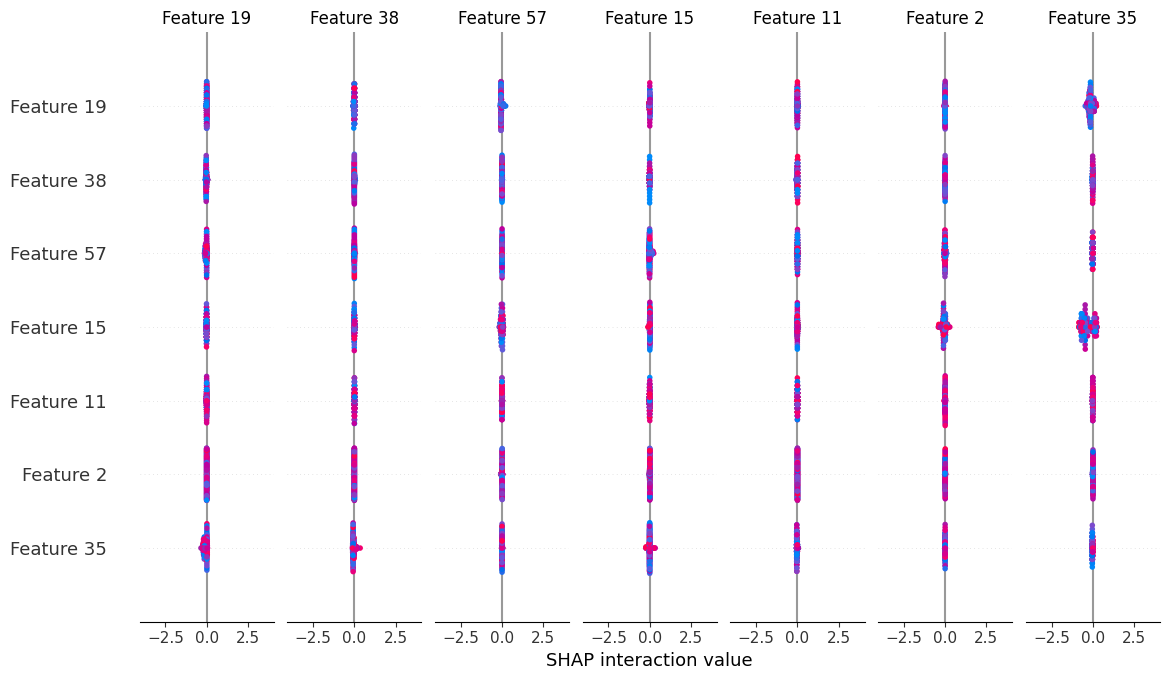

In [5]:
shap.summary_plot(
    shap_values,
    X_shap,
    show=True
)


In [6]:
import numpy as np
import pandas as pd



In [7]:
job_embeddings = np.load("job_embeddings.npy")
course_embeddings = np.load("course_embeddings.npy")

jobs = pd.read_csv("combined_jobs_cleaned.csv")
courses = pd.read_csv("coursera_cleaned.csv")


In [8]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(job_embeddings, course_embeddings)


In [9]:
def recommend_courses_for_job(job_index, top_n=5):
    scores = similarity_matrix[job_index]
    top_indices = scores.argsort()[::-1][:top_n]

    return courses.iloc[top_indices][
        ['course_title', 'course_organization', 'course_difficulty', 'course_rating']
    ]


In [10]:
# Example: recommend courses for first job posting
recommend_courses_for_job(job_index=0, top_n=5)


,course_title,course_organization,course_difficulty,course_rating
297,Excel/VBA for Creative Problem Solving,University of Colorado Boulder,Beginner,4.8
295,Excel Skills for Business: Intermediate II,Macquarie University,Intermediate,4.8
298,"Excel/VBA for Creative Problem Solving, Part 1",University of Colorado Boulder,Beginner,4.8
294,Excel Skills for Business: Intermediate I,Macquarie University,Intermediate,4.9
111,Business English Communication Skills,University of Washington,Intermediate,4.7


In [11]:
def recommend_courses_for_career(career_label, top_n=5):
    job_idxs = jobs[jobs['career_label'] == career_label].index

    if len(job_idxs) == 0:
        return None

    avg_embedding = job_embeddings[job_idxs].mean(axis=0)
    scores = cosine_similarity([avg_embedding], course_embeddings)[0]
    top_indices = scores.argsort()[::-1][:top_n]

    return courses.iloc[top_indices][
        ['course_title', 'course_organization', 'course_difficulty', 'course_rating']
    ]


In [13]:
jobs['career_label'].value_counts().head(20)


career_label
sales executive                   138
account executive                  91
accounts executive                 52
marketing executive                51
quantity surveyor                  49
graphic designer                   47
account assistant                  44
admin assistant                    43
business development executive     42
project manager                    40
technician                         39
accountant                         38
project engineer                   37
site supervisor                    37
admin executive                    33
finance manager                    31
warehouse assistant                31
finance executive                  29
senior account executive           28
purchasing executive               28
Name: count, dtype: int64

In [14]:
jobs['career_label'].unique()[:20]


array(['data centre specialist (malaysia)',
       'assistant manager, corporates audit (based in hong kong)',
       'cloud engineer', 'senior associate - financial risk management',
       'customer service representative (cantonese speaker) - support hong kong market',
       'gaming technician assistant (team ladies)', 'sales executive',
       'big data engineer - cloud', 'database engineer - cloud',
       'huawei cloud delivery engineer (cloud migration engineer)',
       'sales coordinator',
       'telemarketer x10 | basic + comms | work in sg **interview 6-7 nov in kl',
       '[based in sg] high basic + commission + good benefits telemarketing executive',
       'research associate/ researcher/ internship',
       'accounts associate (accounting firm)',
       'eoi- facilities manager_soft service (penang)',
       'division manager', 'cloud professional service solution manager',
       'customer service associate (melaka)',
       'customer service associate (ipoh)'], dtyp

In [16]:
recommend_courses_for_career("accounts executive", top_n=5)


,course_title,course_organization,course_difficulty,course_rating
291,Excel Skills for Business,Macquarie University,Beginner,4.9
295,Excel Skills for Business: Intermediate II,Macquarie University,Intermediate,4.8
292,Excel Skills for Business: Advanced,Macquarie University,Intermediate,4.7
297,Excel/VBA for Creative Problem Solving,University of Colorado Boulder,Beginner,4.8
294,Excel Skills for Business: Intermediate I,Macquarie University,Intermediate,4.9
